<a href="https://colab.research.google.com/github/neuroowl/PhDThesis/blob/master/Model_BLA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Importing libraries

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from time import time as tm
import warnings
warnings.filterwarnings('ignore')
# import sys
# np.set_printoptions(threshold=sys.maxsize)
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/MyDrive/neuro_comp

# Parameters

Neuron parameters were based on [my electrophysiological data](https://neuroowl.github.io/PhDThesis/results.html#cx3cl1cx3cr1-signaling-in-the-basolateral-nucleus-of-the-amygdala) from basolateral amygdala (BLA) pyramidal-like neurons (V_reset, C_m, V_th, tau_m) or according to [Pendyam et al., 2013](https://journals.physiology.org/doi/full/10.1152/jn.00961.2012).

Poisson input, as a background input, was set so that it matched spontaneous activity of excitatory neurons in the BLA (2-3 Hz; [Herry et al., 2008](https://www.nature.com/articles/nature07166)). 

The proportion of numbers of excitatory and inhibitory neurons were similar as in [Vlachos et al, 2011](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1001104), and are around 1% of estimated biological number of BLA neurons.

Connection probabilies between inhibitory and excitatory cells were used according to [Vlachos et al, 2011](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1001104).

In [2]:
# Defining parameters - parameters taken from  Richter&Gjorgjieva, 2021


def default_pars(**kwargs):
  pars = {}

  # typical neuron parameters#
  pars['C_m'] = 200      # membrane capacitance [pF] # my data 207
  pars['g_L'] = 10       # leak conductance [nS]
  pars['E_L'] = -75      # leak reversal potential [mV] # Pendyam, 2013
  pars['V_th'] = -50     # threshold current
  pars['V_reset'] = -65  # Post-spike reset potential [mV] # my data, exactly -64 Pendyam, 2013: -69.5
  pars['tau_m'] = 24     # membrane time constant [ms] # my data; Pendyam, 2013 - 30ms
  pars['V_init'] = -65   # initial potential [mV] # my data from protocol, but not used in this code
  pars['DT'] = 2         # absolute refractory time (ms) # neuromatch: tref
  #pars['VT'] = -36       # threshold found with constant (rheobase) current - from my data
  pars['Vlb'] = -80      # lower boundary


  # typical Poisson input parameters#
  pars['taux'] = 5        # Poisson time constant [ms] #from Richter & Gjorgjieva, Kris code: 10
  pars['jx'] = 15         # Poisson weight # 15
  pars['Nx'] = 350        # number of Poisson neurons  # it was 1000
  pars['rx'] = 5/1000     # noise amplitute [Hz] ?


  # typical excitatory and inhibitory synaptic transmission parameters
  pars['VE'] = 0          # Excitatory reversal potential [mV]
  pars['VI'] = -85        # Inhibitory reversal potential [mV]
  pars['N_E'] = 340       # nr of excitatory neurons # Kris code 8000
  pars['N_I'] = 60        # nr of inhibitory neurons # Kris code 2000
  pars['tau_E'] = 8       # excitatory synaptic conductance time constant [ms] # Richter & Gjorgjieva 5
  pars['tau_I'] = 4       # inhibitory synaptic conductance time constant [ms] #  Richter & Gjorgjieva 5

  # Connection probabilities
  pars['pee'] = 0.01      # connection probability of exc to exc cell # Vlachos 2011
  pars['pei'] = 0.15      # connection probability of inh to exc cell # Vlachos 2011
  pars['pie'] = 0.15      # connection probability of exc to inh cell # Vlachos 2011
  pars['pii'] = 0.1       # connection probability of inh to inh cell # Vlachos 2011
  pars['pex'] = 0.1       # connection probability of Poisson to exc cell
  pars['pix'] = 0.1       # connection probability of Poisson to inh cell

  # Synaptic weights
  pars['jee'] = 350       # synaptic weight from exc to exc cell # 350
  pars['jei'] = -2100     # synaptic weight from inh to exc cell
  pars['jie'] = 2000      # synaptic weight from exc to inh cell # 1575
  pars['jii'] = -3500     # synaptic weight from inh to inh cell
  pars['jex'] = 2250      # synaptic weight from Poisson to exc cell # 3000
  pars['jix'] = 2000      # synaptic weight from Poisson to inh cell # 1500

  # conductance
  pars['gE_bar'] = 2.4    # excitatory conductance [nS] # not used
  pars['gI_bar'] = 2.4    # inhibitory conductance [nS] # not used

  # simulation parameters #
  pars['T'] = 10000      # Total duration of simulation [ms]
  pars['dt'] = .1         # Simulation time step [ms]

  # external parameters if any #
  for k in kwargs:
    pars[k] = kwargs[k]

  pars['time'] = np.arange(0, pars['T'], pars['dt'])  # Vector of discretized time points [ms]

  return pars


pars = default_pars()
# print(pars)

# Poisson Input


Theoretical mean of Ix: 26.25
Empirical mean of Ix: 25.95431052121314


Text(0, 0.5, 'synaptic input (mV)')

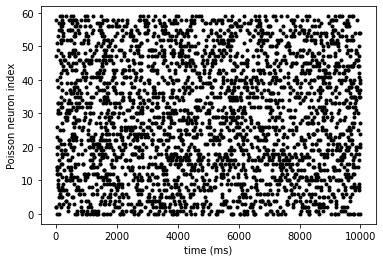

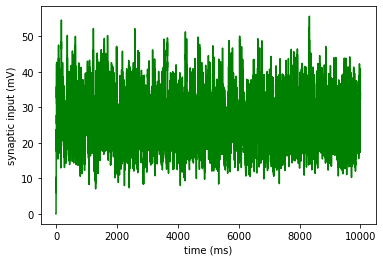

In [3]:
# buiding poisson spike trains

def Poisson_generator(pars, myseed=False, Nx = pars["Nx"]):
  """
  Generates poisson trains and produces raster plot

  Args:
    pars       : parameter dictionary
    myseed     : random seed. int or boolean
    Nx         : number of Poisson neurons

  Returns:
    sx         : matrix with two rows - s[0,:] being a spike times vector
                and sx[1,:] is a vector of associated neuron indices
    Ix         : Input current
    Ixbar      : Theoretical input current
    numspikesX : the total number of spikes
  """

  # Retrieve parameters
  T = pars['T']
  dt = pars['dt']
  time = pars['time']
  rx, taux = pars['rx'], pars['taux']
  jx = pars['jx']
  Nt=len(time)
 
  # set random seed
  if myseed:
      np.random.seed(seed=myseed)
  else:
      np.random.seed()

  # The total number of spikes obeys a Poisson
  # distribution with expectation rx*Nx*T
  numspikesX=np.random.poisson(rx*Nx*T)
  sx=np.zeros((2,numspikesX))

  # Spike times and indices are uniformly distributed
  # once we condition on the total number of spikes
  sx[0,:]=np.random.rand(numspikesX)*T
  sx[1,:]=np.random.randint(0,Nx,size=numspikesX)

  # Sort the spike times 
  temp=np.argsort(sx[0,:])
  sx=sx[:,temp]

  # Initialize Ix
  Ix=np.zeros_like(time)

  # Implement the ODE version of the Ix model
  ix=0
  for i in range(1,Nt):
    Ix[i]=Ix[i-1]-dt*Ix[i-1]/taux
    while (ix<numspikesX and sx[0,ix]<=i*dt):
      Ix[i]+=jx/taux
      ix+=1

  # This is the theoretical stationary mean value
  # of Ix, i.e., E[Ix]
  Ixbar=Nx*jx*rx

  return sx, Ix, Ixbar, numspikesX

# Get parameters
# pars = default_pars(Nx= 1000, rx = 5/1000)

# Simulate Poisson train
sx, Ix, Ixbar, numspikesX = Poisson_generator(pars, myseed = 2022)

print('Theoretical mean of Ix:',Ixbar)
print('Empirical mean of Ix:',np.mean(Ix))

# Raster plot
numplot=60 # Number of neurons to plot

plt.figure()
plt.plot(sx[0,sx[1,:]<numplot],sx[1,sx[1,:]<numplot],'k.')
plt.ylabel('Poisson neuron index')
plt.xlabel('time (ms)')

# Plot Ix and compare to predicted mean
plt.figure()
plt.plot(pars['time'],Ix,'g')
plt.plot(pars['time'],Ixbar+0*pars['time'],'g--')
plt.xlabel('time (ms)')
plt.ylabel('synaptic input (mV)')


# Modeling a recurrent network (equations)

Recurrent connections between the $N$ neurons, $N_e$ of which are excitatory and $N_i$ are inhibitory. 

This makes three populations altogether: An external population of Poisson processes (x), the downstream excitatory population (e), and the downstream inhibitory population (i). 
The connection probability from population $b=e,i,x$ to population $a=e,i$ is denoted $p_{ab}$ and the synaptic weight by $j_{ab}$. 

The synaptic current from population $b=e,i,x$ to population $a=e,i$ obeys
$$
\tau_{b}\frac{d\vec I_{ab}}{dt}=-\vec I_{ab}
$$
with the added rule
$$
\vec I_{ab}(t^b_{i,k})\gets \vec I_x(t^b_{i,k})+J_{ab}(:,k)/\tau_b
$$
where $t^b_{i,k}$ is the $i$th spike of neuron $k$ in population $b$ and $J_{ab}$ is the connection matrix from from population $b=e,i,x$ to population $a=e,i$.


The membrane potentials of neurons in population $a=e,i$ obey
$$
\tau_m \frac{d\vec V_a}{dt}=-(\vec V_a-E_L)+D_T e^{(\vec V_a-V_T)/D_T}+\vec I_{ae}+\vec I_{ai}+\vec I_{ax}
$$
with the added rule
$$
V_j(t)\ge V_{th}\Rightarrow V_j(t)\gets V_{re},\textrm{ record a spike in neuron }j
$$

**Theory:**
The mean input from $b$ to $a$ is given by
$$
\overline{I_{ab}}=w_{ab}r_b
$$
where
$$
w_{ab}=N_b p_{ab}j_{ab}
$$
and $r_b$ is the mean rate of neurons in population $b$. If 
$$
j_{ab}\sim 1/\sqrt N
$$ 
where $N_b\sim N$ then 
$$
\overline{I_{ab}}\sim\sqrt N.
$$
Now let 
$$
\overline{I_a}=I_{ae}+I_{ai}+I_{ax}
$$
be the mean-field total input to neurons in population $a$. 
Then we can only have 
$$
r_a,\overline{I_a}\sim\mathcal O(1) 
$$
if there is a cancellation between $I_{ae}$, $I_{ai}$, and $I_{ax}$ in the large $N$ limit. We can write 
$$
{\bf I}=\left[\begin{array}{c}\overline{I_e}\\ \overline{I_i}\end{array}\right]=W{\bf r}+W_x r_x
$$
where 
$$
W=\left[\begin{array}{cc}w_{ee} & w_{ei}\\ w_{ie} & w_{ii}\end{array}\right]
$$
$$
W_x=\left[\begin{array}{c}w_{ex}\\ w_{ix}\end{array}\right]
$$
and
$$
{\bf r}=\left[\begin{array}{c}{r_e}\\ {r_i}\end{array}\right]
$$
Cancellation requires that 
$$
W{\bf r}\approx -W_x r_x
$$
in the large $N$ limit, so 
$$
\lim_{N\to\infty}{\bf r}=-W^{-1}W_x r_x
$$


# Recurrent network without changing any parameters during simulation (function)

In [ ]:
# Modeling a recurrent network

def recurrent_simulation(pars):
  """
  Simulate the recurrent network 

  Args:
    pars      : parameter dictionary


  Returns:
    Ve        : membrane potential of excitatory neurons 
    Vi        : membrane potential of inhibitory neurons 
    Iee       : synaptic current from excitatory to excitatory neurons
    Iei       : synaptic current from inhibitory to excitatory neurons
    Iie       : synaptic current from excitatory to inhibitory neurons
    Iii       : synaptic current from inhibitory to inhibitory neurons
    Iex       : synaptic current from Poisson to excitatory neurons
    Iix       : synaptic current from Poisson to excitatory neurons  
    se        : numpy array, where se[0] - indeces of excitatory neurons, and se[1] the time of their spikes
    si        : numpy array, where si[0] - indeces of inhibitory neurons, and si[1] the time of their spikes
    MeaneRate : Mean Rate of excitatory neurons
    MeaniRate : Mean Rate of inhibitory neurons
  """

  # Retrieve parameters
  dt, time, T = pars['dt'], pars['time'], pars['T']
  Nt = len(time)
  V_reset, E_L, tau_m = pars['V_reset'], pars['E_L'], pars['tau_m']
  DT = pars['DT']
  V_th, Vlb = pars['V_th'], pars['Vlb']
  N_E, N_I, Nx = pars['N_E'], pars['N_I'], pars['Nx']
  rx = pars['rx']
  pee, pei, pex = pars['pee'], pars['pei'], pars['pex']
  pie, pii, pix = pars['pie'], pars['pii'], pars['pix']
  jee, jei, jex = pars['jee'], pars['jei'], pars['jex']
  jie, jii, jix = pars['jie'], pars['jii'], pars['jix']
  tau_E, tau_I, taux = pars['tau_E'], pars['tau_I'], pars['taux']

  # Number and rate of Poisson processes
  N=N_E+N_I

  # Synaptic weights
  jee=jee/np.sqrt(N)
  jei=jei/np.sqrt(N)
  jie=jie/np.sqrt(N)
  jii=jii/np.sqrt(N)
  jex=jex/np.sqrt(N)
  jix=jix/np.sqrt(N)


  # Connectivity matrix from presynaptic population 
  # to postsynaptic population
  Jee=jee*np.random.binomial(1,pee,(N_E,N_E))
  Jei=jei*np.random.binomial(1,pei,(N_E,N_I))
  Jie=jie*np.random.binomial(1,pie,(N_I,N_E))
  Jii=jii*np.random.binomial(1,pii,(N_I,N_I))
  Jex=jex*np.random.binomial(1,pex,(N_E,Nx))
  Jix=jix*np.random.binomial(1,pix,(N_I,Nx))

  # Simulate Poisson input
  sx, Ix, Ixbar, numspikesX = Poisson_generator(pars)

  # Initialize V and Ix
  Iee=np.zeros(N_E)
  Iei=np.zeros(N_E)
  Iie=np.zeros(N_I)
  Iii=np.zeros(N_I)
  Iex=np.zeros(N_E)
  Iix=np.zeros(N_I)
  Ve=np.random.rand(N_E)*(V_th-E_L)+E_L
  Vi=np.random.rand(N_I)*(V_th-E_L)+E_L

  # Initialize postsynaptic spike train with the same data structure as for sx
  maxnumespikes=(int)(N_E*T*100/1000)
  se=-1+np.zeros((2,maxnumespikes))
  maxnumispikes=(int)(N_I*T*100/1000)
  si=-1+np.zeros((2,maxnumispikes))
  nespike=0
  nispike=0
  ix=0
  startsim = tm()
  for i in range(1,Nt):
    
    # Update synaptic current
    Iee=Iee-dt*Iee/tau_E
    Iei=Iei-dt*Iei/tau_I
    Iie=Iie-dt*Iie/tau_E
    Iii=Iii-dt*Iii/tau_I
    Iex=Iex-dt*Iex/taux
    Iix=Iix-dt*Iix/taux

    while (ix<numspikesX and sx[0,ix]<=i*dt):
      Iex+=Jex[:,(int)(sx[1,ix])]/taux
      Iix+=Jix[:,(int)(sx[1,ix])]/taux
      ix+=1

    # Update membrane potential
    Ve=Ve+dt*(Iee+Iei+Iex+(E_L-Ve)+DT*np.exp((Ve-V_th)/DT))/tau_m
    Ve=np.maximum(Ve,Vlb)
    Vi=Vi+dt*(Iie+Iii+Iix+(E_L-Vi)+DT*np.exp((Vi-V_th)/DT))/tau_m
    Vi=np.maximum(Vi,Vlb)

    # Find which e neurons spiked      
    Iespike = np.nonzero(Ve>=V_th)[0]        
    if Iespike.any():
        # Store spike times and neuron indices
        if (nespike+len(Iespike)<=maxnumespikes):
            se[0,nespike:nespike+len(Iespike)]=dt*i
            se[1,nespike:nespike+len(Iespike)]=Iespike

        # Reset membrane potential
        Ve[Iespike]=V_reset

        # Propagate spikes
        Iee=Iee+Jee[:,Iespike].sum(axis = 1)/tau_E
        Iie=Iie+Jie[:,Iespike].sum(axis = 1)/tau_E
    
        # Update cumulative number of spikes (excitatory cells)
        nespike=nespike+len(Iespike)

    # Find which i neurons spiked      
    Iispike = np.nonzero(Vi>=V_th)[0]        
    if Iispike.any():
        # Store spike times and neuron indices
        if (nispike+len(Iispike)<=maxnumispikes):
            si[0,nispike:nispike+len(Iispike)]=dt*i
            si[1,nispike:nispike+len(Iispike)]=Iispike

        # Reset membrane potential
        Vi[Iispike]=V_reset

        # Propagate spikes
        Iei=Iei+Jei[:,Iispike].sum(axis = 1)/tau_I
        Iii=Iii+Jii[:,Iispike].sum(axis = 1)/tau_I
        
    
        # Update cumulative number of spikes (interneurons)
        nispike=nispike+len(Iispike)


  # Get rid of unused space in s
  se=se[:,:nespike]
  si=si[:,:nispike]

  # Mean rates
  MeaneRate=nespike/(N_E*T)
  MeaniRate=nispike/(N_I*T)
  print('Mean rate of excitatory neuron=',MeaneRate*1000,'Hz')
  print('Mean rate of inhibitory neuron=',MeaniRate*1000,'Hz')

  # Raster plots and histograms of Firing rates
  numplot=60 # Number of neurons to plot
  bins_nr = int(Nt/1000)

  plt.figure()
  plt.plot(sx[0,sx[1,:]<numplot],sx[1,sx[1,:]<numplot],'k.')
  plt.ylabel('Poisson neuron index')
  plt.xlabel('time (ms)')
  plt.xlim(0, T)
  plt.title('Raster plot of Poisson neurons(limited to 60 neurons)')

  plt.figure()
  n_sx, bins_sx, _ = plt.hist(sx[0], bins = bins_nr)
  plt.title('Histogram of the sum of Poisson spikes binned in time')

  plt.figure()
  plt.plot(se[0,se[1,:]<numplot],se[1,se[1,:]<numplot],'k.')
  plt.ylabel('Excitatory neuron index')
  plt.xlabel('time (ms)')
  plt.xlim(0, T)
  plt.title('Raster plot of Excitatory neurons(limited to 60 neurons)')

  plt.figure()
  n_se, bins_se, _ = plt.hist(se[0], bins = bins_nr)
  plt.title('Histogram of the sum of Excitatory spikes binned in time')

  plt.figure()
  plt.plot(si[0],si[1],'k.')
  plt.ylabel('Inhibitory neuron index')
  plt.xlabel('time (ms)')
  plt.xlim(0, T)
  plt.title('Raster plot of Inhibitory neurons')

  plt.figure()
  n_si, bins_si, _ = plt.hist(si[0], bins = bins_nr)
  plt.title('Histogram of the sum of Inhibitory spikes binned in time')

  # Mean-field weights
  wee=N_E*pee*jee
  wei=N_I*pei*jei
  wie=N_E*pie*jie
  wii=N_I*pii*jii
  wex=Nx*pex*jex
  wix=Nx*pix*jix

  # Mean rates predicted by balanced network approx
  W=np.array([[wee,wei],[wie,wii]])
  Wx=np.array([[wex],[wix]])
  rBal=-np.linalg.inv(W)@Wx*rx

  print('Theoretical exc rate approx=',rBal[0][0]*1000,'Hz')
  print('Theoretical inh rate approx=',rBal[1][0]*1000,'Hz')

  # Plot histograms of input currents to vizualize balance
  plt.figure()
  plt.hist(Iee+Iex, alpha = 0.7)
  plt.hist(Iei, alpha = 0.7)
  plt.hist(Iee+Iex+Iei, alpha = 0.7)
  plt.gca().legend(('Total excitatory input to excitatory cells',
                    'Total inhibitory input to excitatory cells',
                    'Total input to excitatory cells'))
  plt.show()

  print('Mean excitatory, inhibitory, total inputs to excitatory cells:',(Iee+Iex).mean(),(Iei).mean(),(Iee+Iex+Iei).mean())

  # Time for simulation
  simtime = tm()-startsim
  print('Time for simulation=',simtime,'sec')

  return Ve, Vi, si, se, Iee, Iei, Iie, Iii, Iex, Iix, MeaneRate, MeaniRate

Ve, Vi, si, se, Iee, Iei, Iie, Iii, Iex, Iix, MeaneRate, MeaniRate = recurrent_simulation(pars)

# Simulation of CX3CL1 application by changing the threshold current

According to [my data](https://neuroowl.github.io/PhDThesis/results.html#cx3cl1cx3cr1-signaling-in-the-basolateral-nucleus-of-the-amygdala), CX3CL1 application on acute brain slices resulted in an increased threshold current (V_th) from -50 mV to -47 mV. 
Here, the threshold current (V_th) is changed in the middle of simulation.

In [ ]:
# Modeling a recurrent network

def recurrent_simulation_threshold(pars):
  """
  Simulate the recurrent network and increase the threshold current by 3 mV in the middle of simulation

  Args:
    pars      : parameter dictionary


   Returns:
    Ve        : membrane potential of excitatory neurons 
    Vi        : membrane potential of inhibitory neurons 
    Iee       : synaptic current from excitatory to excitatory neurons
    Iei       : synaptic current from inhibitory to excitatory neurons
    Iie       : synaptic current from excitatory to inhibitory neurons
    Iii       : synaptic current from inhibitory to inhibitory neurons
    Iex       : synaptic current from Poisson to excitatory neurons
    Iix       : synaptic current from Poisson to excitatory neurons  
    se        : numpy array, where se[0] - indeces of excitatory neurons, and se[1] the time of their spikes
    si        : numpy array, where si[0] - indeces of inhibitory neurons, and si[1] the time of their spikes
    MeaneRate : Mean Rate of excitatory neurons
    MeaniRate : Mean Rate of inhibitory neurons
  """

  # Retrieve parameters
  dt, time, T = pars['dt'], pars['time'], pars['T']
  Nt = len(time)
  V_reset, E_L, tau_m = pars['V_reset'], pars['E_L'], pars['tau_m']
  DT = pars['DT']
  V_th, Vlb = pars['V_th'], pars['Vlb']
  N_E, N_I, Nx = pars['N_E'], pars['N_I'], pars['Nx']
  rx = pars['rx']
  pee, pei, pex = pars['pee'], pars['pei'], pars['pex']
  pie, pii, pix = pars['pie'], pars['pii'], pars['pix']
  jee, jei, jex = pars['jee'], pars['jei'], pars['jex']
  jie, jii, jix = pars['jie'], pars['jii'], pars['jix']
  tau_E, tau_I, taux = pars['tau_E'], pars['tau_I'], pars['taux']

  V_th_ch = V_th + 3 # difference between baseline and CX3CL1 condition (3mV)


  # Number and rate of Poisson processes
  N=N_E+N_I

  # Synaptic weights
  jee=jee/np.sqrt(N)
  jei=jei/np.sqrt(N)
  jie=jie/np.sqrt(N)
  jii=jii/np.sqrt(N)
  jex=jex/np.sqrt(N)
  jix=jix/np.sqrt(N)


  # Connectivity matrix from presynaptic population 
  # to postsynaptic population
  Jee=jee*np.random.binomial(1,pee,(N_E,N_E))
  Jei=jei*np.random.binomial(1,pei,(N_E,N_I))
  Jie=jie*np.random.binomial(1,pie,(N_I,N_E))
  Jii=jii*np.random.binomial(1,pii,(N_I,N_I))
  Jex=jex*np.random.binomial(1,pex,(N_E,Nx))
  Jix=jix*np.random.binomial(1,pix,(N_I,Nx))

  # Simulate Poisson input
  sx, Ix, Ixbar, numspikesX = Poisson_generator(pars)

  # Initialize V and Ix
  Iee=np.zeros(N_E)
  Iei=np.zeros(N_E)
  Iie=np.zeros(N_I)
  Iii=np.zeros(N_I)
  Iex=np.zeros(N_E)
  Iix=np.zeros(N_I)
  Ve_b=np.random.rand(N_E)*(V_th-E_L)+E_L # during baseline
  Ve_ch=np.random.rand(N_E)*(V_th_ch-E_L)+E_L # during CX3CL1 application
  Vi_b=np.random.rand(N_I)*(V_th-E_L)+E_L # during baseline
  Vi_ch=np.random.rand(N_I)*(V_th_ch-E_L)+E_L # during CX3CL1 application

  # Initialize postsynaptic spike train with the same data structure as for sx
  maxnumespikes=(int)(N_E*T*100/1000)
  se=-1+np.zeros((2,maxnumespikes))
  maxnumispikes=(int)(N_I*T*100/1000)
  si=-1+np.zeros((2,maxnumispikes))
  nespike=0
  nispike=0
  ix=0
  # startsim = tm()
  for i in range(1,Nt):
    
    # Update synaptic current
    Iee=Iee-dt*Iee/tau_E
    Iei=Iei-dt*Iei/tau_I
    Iie=Iie-dt*Iie/tau_E
    Iii=Iii-dt*Iii/tau_I
    Iex=Iex-dt*Iex/taux
    Iix=Iix-dt*Iix/taux

    while (ix<numspikesX and sx[0,ix]<=i*dt):
      Iex+=Jex[:,(int)(sx[1,ix])]/taux
      Iix+=Jix[:,(int)(sx[1,ix])]/taux
      ix+=1

    # "baseline condition"
    if (i <= (Nt/2)) :

      # Update membrane potential
      Ve_b=Ve_b+dt*(Iee+Iei+Iex+(E_L-Ve_b)+DT*np.exp((Ve_b-V_th)/DT))/tau_m
      Ve_b=np.maximum(Ve_b,Vlb)
      Vi_b=Vi_b+dt*(Iie+Iii+Iix+(E_L-Vi_b)+DT*np.exp((Vi_b-V_th)/DT))/tau_m
      Vi_b=np.maximum(Vi_b,Vlb)

      # Find which e neurons spiked      
      Iespike = np.nonzero(Ve_b>=V_th)[0]        
      if Iespike.any():
          # Store spike times and neuron indices
          if (nespike+len(Iespike)<=maxnumespikes):
              se[0,nespike:nespike+len(Iespike)]=dt*i
              se[1,nespike:nespike+len(Iespike)]=Iespike

          # Reset membrane potential
          Ve_b[Iespike]=V_reset

          # Propagate spikes
          Iee=Iee+Jee[:,Iespike].sum(axis = 1)/tau_E
          Iie=Iie+Jie[:,Iespike].sum(axis = 1)/tau_E
      
          # Update cumulative number of spikes (excitatory cells)
          nespike=nespike+len(Iespike)

      # Find which i neurons spiked      
      Iispike = np.nonzero(Vi_b>=V_th)[0]        
      if Iispike.any():
          # Store spike times and neuron indices
          if (nispike+len(Iispike)<=maxnumispikes):
              si[0,nispike:nispike+len(Iispike)]=dt*i
              si[1,nispike:nispike+len(Iispike)]=Iispike

          # Reset membrane potential
          Vi_b[Iispike]=V_reset

          # Propagate spikes
          Iei=Iei+Jei[:,Iispike].sum(axis = 1)/tau_I
          Iii=Iii+Jii[:,Iispike].sum(axis = 1)/tau_I
          
      
          # Update cumulative number of spikes (interneurons)
          nispike=nispike+len(Iispike)



    # CX3CL1 application    
    else :

      # Update membrane potential
      Ve_ch=Ve_ch+dt*(Iee+Iei+Iex+(E_L-Ve_ch)+DT*np.exp((Ve_ch-V_th_ch)/DT))/tau_m
      Ve_ch=np.maximum(Ve_ch,Vlb)
      Vi_ch=Vi_ch+dt*(Iie+Iii+Iix+(E_L-Vi_ch)+DT*np.exp((Vi_ch-V_th_ch)/DT))/tau_m
      Vi_ch=np.maximum(Vi_ch,Vlb)

         # Find which e neurons spiked      
      Iespike = np.nonzero(Ve_ch>=V_th_ch)[0]        
      if Iespike.any():
          # Store spike times and neuron indices
          if (nespike+len(Iespike)<=maxnumespikes):
              se[0,nespike:nespike+len(Iespike)]=dt*i
              se[1,nespike:nespike+len(Iespike)]=Iespike

          # Reset membrane potential
          Ve_ch[Iespike]=V_reset

          # Propagate spikes
          Iee=Iee+Jee[:,Iespike].sum(axis = 1)/tau_E
          Iie=Iie+Jie[:,Iespike].sum(axis = 1)/tau_E
      
          # Update cumulative number of spikes (excitatory cells)
          nespike=nespike+len(Iespike)

      # Find which i neurons spiked      
      Iispike = np.nonzero(Vi_ch>=V_th_ch)[0]        
      if Iispike.any():
          # Store spike times and neuron indices
          if (nispike+len(Iispike)<=maxnumispikes):
              si[0,nispike:nispike+len(Iispike)]=dt*i
              si[1,nispike:nispike+len(Iispike)]=Iispike

          # Reset membrane potential
          Vi_ch[Iispike]=V_reset


    

          # Propagate spikes
          Iei=Iei+Jei[:,Iispike].sum(axis = 1)/tau_I
          Iii=Iii+Jii[:,Iispike].sum(axis = 1)/tau_I
          
      
          # Update cumulative number of spikes (interneurons)
          nispike=nispike+len(Iispike)


  # Get rid of unused space in s
  se=se[:,:nespike]
  si=si[:,:nispike]


  # Raster plots and histograms of Firing rates
  numplot=60 # Number of neurons to plot
  bins_nr = int(Nt/1000)

  plt.figure()
  plt.plot(sx[0,sx[1,:]<numplot],sx[1,sx[1,:]<numplot],'k.')
  plt.ylabel('Poisson neuron index')
  plt.xlabel('time (ms)')
  plt.xlim(0, T)
  plt.title('Raster plot of Poisson neurons(limited to 60 neurons)')

  # plt.figure()
  # n_sx, bins_sx, _ = plt.hist(sx[0], bins = bins_nr)
  # plt.title('Histogram of the sum of Poisson spikes binned in time')

  plt.figure()
  plt.plot(se[0,se[1,:]<numplot],se[1,se[1,:]<numplot],'k.')
  plt.ylabel('Excitatory neuron index')
  plt.xlabel('time (ms)')
  plt.xlim(0, T)
  plt.title('Raster plot of Excitatory neurons(limited to 60 neurons)')

  # plt.figure()
  # n_se, bins_se, _ = plt.hist(se[0], bins = bins_nr)
  # plt.title('Histogram of the sum of Excitatory spikes binned in time')

  plt.figure()
  plt.plot(si[0],si[1],'k.')
  plt.ylabel('Inhibitory neuron index')
  plt.xlabel('time (ms)')
  plt.xlim(0, T)
  plt.title('Raster plot of Inhibitory neurons')

  # plt.figure()
  # n_si, bins_si, _ = plt.hist(si[0], bins = bins_nr)
  # plt.title('Histogram of the sum of Inhibitory spikes binned in time')

  # Making plots of mean firing rate 
  dt_1 = 100 # size of bins
  time_1 = np.arange(0, 10001, dt_1) # making vector of time for the firing rate
  exc_spikes = np.zeros(len(time_1)) # making an empty vector equal to those of vector time
  exc_spikes = np.bincount(np.digitize(se[0], time_1, right = 1)) # making bins and and couting all spikes in the bins
  exc_spikes = exc_spikes * 10 /(N_E) # dividing it by number of neurons and size of bins, to have mean firing
  if len(exc_spikes) > len(time_1) :
    diff = len(time_1) - len(exc_spikes) 
    exc_spikes = exc_spikes[:diff]
  inh_spikes = np.zeros(len(time_1))
  inh_spikes = np.bincount(np.digitize(si[0], time_1, right = 1))
  inh_spikes = inh_spikes * 10 /(N_I) 

  while len(inh_spikes) > len(time_1) :
    inh_spikes = inh_spikes[:-1]

  plt.figure()
  plt.plot(time_1, exc_spikes, 'g', label = "principal cells")
  plt.plot(time_1, inh_spikes, 'r', label = "interneurons")
  plt.xlabel("Time (ms)")
  plt.ylabel("Firing rate (Hz)")
  plt.legend()
  plt.title('Mean Firing rate of excitatory and inhibitory neurons')
  plt.axvline(x = 5000)
  plt.show()

  # Measuring Mean Firing Rate
  temp_e = se[0]
  temp_i = si[0]
  MeaneRate_b=(len(temp_e[temp_e <= T/2]))/(N_E*(T/2/1000))
  MeaneRate_ch=(len(temp_e[temp_e > T/2]))/(N_E*(T/2/1000))
  MeaniRate_b=(len(temp_i[temp_i <= T/2]))/(N_I*(T/2/1000))
  MeaniRate_ch=(len(temp_i[temp_i > T/2]))/(N_I*(T/2/1000))

  print('Mean rate of excitatory neuron during baseline=',MeaneRate_b, 'Hz')
  print('Mean rate of excitatory neuron during CX3CL1 application=',MeaneRate_ch, 'Hz')
  print('Mean rate of inhibitory neuron during baseline=',MeaniRate_b, 'Hz')
  print('Mean rate of inhibitory neuron during CX3CL1 application=',MeaniRate_ch, 'Hz')

  return Ve, Vi, si, se, Iee, Iei, Iie, Iii, Iex, Iix, time, nespike, nispike, Nt, N_E, N_I, T 

Ve, Vi, si, se, Iee, Iei, Iie, Iii, Iex, Iix, time, nespike, nispike, Nt, N_E, N_I, T  = recurrent_simulation_threshold(pars)

# Changing the threshold and seeing the change in the mean firing rates of inhibitory and excitatory populations

In [ ]:
# Modeling a recurrent network

def recurrent_simulation_threshold(pars):
  """
  Simulate the recurrent network and increase the threshold current by 3 mV in the middle of simulation

  Args:
    pars      : parameter dictionary


   Returns:
    Ve        : membrane potential of excitatory neurons 
    Vi        : membrane potential of inhibitory neurons 
    Iee       : synaptic current from excitatory to excitatory neurons
    Iei       : synaptic current from inhibitory to excitatory neurons
    Iie       : synaptic current from excitatory to inhibitory neurons
    Iii       : synaptic current from inhibitory to inhibitory neurons
    Iex       : synaptic current from Poisson to excitatory neurons
    Iix       : synaptic current from Poisson to excitatory neurons  
    se        : numpy array, where se[0] - indeces of excitatory neurons, and se[1] the time of their spikes
    si        : numpy array, where si[0] - indeces of inhibitory neurons, and si[1] the time of their spikes
    MeaneRate : Mean Rate of excitatory neurons
    MeaniRate : Mean Rate of inhibitory neurons
    threshold_vec : vector of change of the threshold
  """
  
  delta_thresholds = []
  delta_MeaniRates = []
  delta_MeaneRates = []

  for delta_threshold in np.arange(0,6, 0.5) :

    # Retrieve parameters
    dt, time, T = pars['dt'], pars['time'], pars['T']
    Nt = len(time)
    V_reset, E_L, tau_m = pars['V_reset'], pars['E_L'], pars['tau_m']
    DT = pars['DT']
    V_th, Vlb = pars['V_th'], pars['Vlb']
    N_E, N_I, Nx = pars['N_E'], pars['N_I'], pars['Nx']
    rx = pars['rx']
    pee, pei, pex = pars['pee'], pars['pei'], pars['pex']
    pie, pii, pix = pars['pie'], pars['pii'], pars['pix']
    jee, jei, jex = pars['jee'], pars['jei'], pars['jex']
    jie, jii, jix = pars['jie'], pars['jii'], pars['jix']
    tau_E, tau_I, taux = pars['tau_E'], pars['tau_I'], pars['taux']



    V_th_ch = V_th + delta_threshold # difference between baseline and CX3CL1 condition (3mV)

    # Number and rate of Poisson processes
    N=N_E+N_I

    # Synaptic weights
    jee=jee/np.sqrt(N)
    jei=jei/np.sqrt(N)
    jie=jie/np.sqrt(N)
    jii=jii/np.sqrt(N)
    jex=jex/np.sqrt(N)
    jix=jix/np.sqrt(N)


    # Connectivity matrix from presynaptic population 
    # to postsynaptic population
    Jee=jee*np.random.binomial(1,pee,(N_E,N_E))
    Jei=jei*np.random.binomial(1,pei,(N_E,N_I))
    Jie=jie*np.random.binomial(1,pie,(N_I,N_E))
    Jii=jii*np.random.binomial(1,pii,(N_I,N_I))
    Jex=jex*np.random.binomial(1,pex,(N_E,Nx))
    Jix=jix*np.random.binomial(1,pix,(N_I,Nx))

    # Simulate Poisson input
    sx, Ix, Ixbar, numspikesX = Poisson_generator(pars)

    # Initialize V and Ix
    Iee=np.zeros(N_E)
    Iei=np.zeros(N_E)
    Iie=np.zeros(N_I)
    Iii=np.zeros(N_I)
    Iex=np.zeros(N_E)
    Iix=np.zeros(N_I)
    Ve_b=np.random.rand(N_E)*(V_th-E_L)+E_L # during baseline
    Ve_ch=np.random.rand(N_E)*(V_th_ch-E_L)+E_L # during CX3CL1 application
    Vi_b=np.random.rand(N_I)*(V_th-E_L)+E_L # during baseline
    Vi_ch=np.random.rand(N_I)*(V_th_ch-E_L)+E_L # during CX3CL1 application

    # Initialize postsynaptic spike train with the same data structure as for sx
    maxnumespikes=(int)(N_E*T*100/1000)
    se=-1+np.zeros((2,maxnumespikes))
    maxnumispikes=(int)(N_I*T*100/1000)
    si=-1+np.zeros((2,maxnumispikes))
    nespike=0
    nispike=0
    ix=0
    # startsim = tm()
    for i in range(1,Nt):
      
      # Update synaptic current
      Iee=Iee-dt*Iee/tau_E
      Iei=Iei-dt*Iei/tau_I
      Iie=Iie-dt*Iie/tau_E
      Iii=Iii-dt*Iii/tau_I
      Iex=Iex-dt*Iex/taux
      Iix=Iix-dt*Iix/taux

      while (ix<numspikesX and sx[0,ix]<=i*dt):
        Iex+=Jex[:,(int)(sx[1,ix])]/taux
        Iix+=Jix[:,(int)(sx[1,ix])]/taux
        ix+=1

      # "baseline condition"
      if (i <= (Nt/2)) :

        # Update membrane potential
        Ve_b=Ve_b+dt*(Iee+Iei+Iex+(E_L-Ve_b)+DT*np.exp((Ve_b-V_th)/DT))/tau_m
        Ve_b=np.maximum(Ve_b,Vlb)
        Vi_b=Vi_b+dt*(Iie+Iii+Iix+(E_L-Vi_b)+DT*np.exp((Vi_b-V_th)/DT))/tau_m
        Vi_b=np.maximum(Vi_b,Vlb)

        # Find which e neurons spiked      
        Iespike = np.nonzero(Ve_b>=V_th)[0]        
        if Iespike.any():
            # Store spike times and neuron indices
            if (nespike+len(Iespike)<=maxnumespikes):
                se[0,nespike:nespike+len(Iespike)]=dt*i
                se[1,nespike:nespike+len(Iespike)]=Iespike

            # Reset membrane potential
            Ve_b[Iespike]=V_reset

            # Propagate spikes
            Iee=Iee+Jee[:,Iespike].sum(axis = 1)/tau_E
            Iie=Iie+Jie[:,Iespike].sum(axis = 1)/tau_E
        
            # Update cumulative number of spikes (excitatory cells)
            nespike=nespike+len(Iespike)

        # Find which i neurons spiked      
        Iispike = np.nonzero(Vi_b>=V_th)[0]        
        if Iispike.any():
            # Store spike times and neuron indices
            if (nispike+len(Iispike)<=maxnumispikes):
                si[0,nispike:nispike+len(Iispike)]=dt*i
                si[1,nispike:nispike+len(Iispike)]=Iispike

            # Reset membrane potential
            Vi_b[Iispike]=V_reset

            # Propagate spikes
            Iei=Iei+Jei[:,Iispike].sum(axis = 1)/tau_I
            Iii=Iii+Jii[:,Iispike].sum(axis = 1)/tau_I
            
        
            # Update cumulative number of spikes (interneurons)
            nispike=nispike+len(Iispike)



      # CX3CL1 application    
      else :


        # Update membrane potential
        Ve_ch=Ve_ch+dt*(Iee+Iei+Iex+(E_L-Ve_ch)+DT*np.exp((Ve_ch-V_th_ch)/DT))/tau_m
        Ve_ch=np.maximum(Ve_ch,Vlb)
        Vi_ch=Vi_ch+dt*(Iie+Iii+Iix+(E_L-Vi_ch)+DT*np.exp((Vi_ch-V_th_ch)/DT))/tau_m
        Vi_ch=np.maximum(Vi_ch,Vlb)

          # Find which e neurons spiked      
        Iespike = np.nonzero(Ve_ch>=V_th_ch)[0]        
        if Iespike.any():
            # Store spike times and neuron indices
            if (nespike+len(Iespike)<=maxnumespikes):
                se[0,nespike:nespike+len(Iespike)]=dt*i
                se[1,nespike:nespike+len(Iespike)]=Iespike

            # Reset membrane potential
            Ve_ch[Iespike]=V_reset

            # Propagate spikes
            Iee=Iee+Jee[:,Iespike].sum(axis = 1)/tau_E
            Iie=Iie+Jie[:,Iespike].sum(axis = 1)/tau_E
        
            # Update cumulative number of spikes (excitatory cells)
            nespike=nespike+len(Iespike)

        # Find which i neurons spiked      
        Iispike = np.nonzero(Vi_ch>=V_th_ch)[0]        
        if Iispike.any():
            # Store spike times and neuron indices
            if (nispike+len(Iispike)<=maxnumispikes):
                si[0,nispike:nispike+len(Iispike)]=dt*i
                si[1,nispike:nispike+len(Iispike)]=Iispike

            # Reset membrane potential
            Vi_ch[Iispike]=V_reset


      

            # Propagate spikes
            Iei=Iei+Jei[:,Iispike].sum(axis = 1)/tau_I
            Iii=Iii+Jii[:,Iispike].sum(axis = 1)/tau_I
            
        
            # Update cumulative number of spikes (interneurons)
            nispike=nispike+len(Iispike)


    # Get rid of unused space in s
    se=se[:,:nespike]
    si=si[:,:nispike]

    # Measuring Mean Firing Rate
    temp_e = se[0]
    temp_i = si[0]
    MeaneRate_b=(len(temp_e[temp_e <= T/2]))/(N_E*(T/2/1000))
    MeaneRate_ch=(len(temp_e[temp_e > T/2]))/(N_E*(T/2/1000))
    delta_MeaneRate = MeaneRate_ch - MeaneRate_b 
    MeaniRate_b=(len(temp_i[temp_i <= T/2]))/(N_I*(T/2/1000))
    MeaniRate_ch=(len(temp_i[temp_i > T/2]))/(N_I*(T/2/1000))
    delta_MeaniRate = MeaniRate_ch - MeaniRate_b

    delta_thresholds.append(delta_threshold)
    delta_MeaniRates.append(delta_MeaniRate)
    delta_MeaneRates.append(delta_MeaneRate)

    print('-'*5,delta_threshold,'-'*5)

    print('Mean rate of excitatory neuron during baseline=',MeaneRate_b, 'Hz')
    print('Mean rate of excitatory neuron during CX3CL1 application=',MeaneRate_ch, 'Hz')
    print('Mean rate of inhibitory neuron during baseline=',MeaniRate_b, 'Hz')
    print('Mean rate of inhibitory neuron during CX3CL1 application=',MeaniRate_ch, 'Hz')

  plt.figure()
  plt.scatter(delta_thresholds, delta_MeaniRates, color = 'red', label = 'interneurons')
  plt.scatter(delta_thresholds, delta_MeaneRates, color = 'green', label = 'principal cells')
  plt.xlabel('Change in threshod (mV)')
  plt.ylabel('Change in Mean Firing Rates (Hz)')
  plt.legend()
  plt.show()

  return Ve, Vi, si, se, Iee, Iei, Iie, Iii, Iex, Iix, time, nespike, nispike, Nt, N_E, N_I, T  

Ve, Vi, si, se, Iee, Iei, Iie, Iii, Iex, Iix, time, nespike, nispike, Nt, N_E, N_I, T   = recurrent_simulation_threshold(pars)

# Only in excitatory population threhold by 3mV

In [ ]:
# Modeling a recurrent network

def recurrent_simulation_threshold_exc(pars):
  """
  Simulate the recurrent network and increase the threshold current by 3 mV in the middle of simulation

  Args:
    pars      : parameter dictionary


   Returns:
    Ve        : membrane potential of excitatory neurons 
    Vi        : membrane potential of inhibitory neurons 
    Iee       : synaptic current from excitatory to excitatory neurons
    Iei       : synaptic current from inhibitory to excitatory neurons
    Iie       : synaptic current from excitatory to inhibitory neurons
    Iii       : synaptic current from inhibitory to inhibitory neurons
    Iex       : synaptic current from Poisson to excitatory neurons
    Iix       : synaptic current from Poisson to excitatory neurons  
    se        : numpy array, where se[0] - indeces of excitatory neurons, and se[1] the time of their spikes
    si        : numpy array, where si[0] - indeces of inhibitory neurons, and si[1] the time of their spikes
    MeaneRate : Mean Rate of excitatory neurons
    MeaniRate : Mean Rate of inhibitory neurons
  """

  # Retrieve parameters
  dt, time, T = pars['dt'], pars['time'], pars['T']
  Nt = len(time)
  V_reset, E_L, tau_m = pars['V_reset'], pars['E_L'], pars['tau_m']
  DT = pars['DT']
  V_th, Vlb = pars['V_th'], pars['Vlb']
  N_E, N_I, Nx = pars['N_E'], pars['N_I'], pars['Nx']
  rx = pars['rx']
  pee, pei, pex = pars['pee'], pars['pei'], pars['pex']
  pie, pii, pix = pars['pie'], pars['pii'], pars['pix']
  jee, jei, jex = pars['jee'], pars['jei'], pars['jex']
  jie, jii, jix = pars['jie'], pars['jii'], pars['jix']
  tau_E, tau_I, taux = pars['tau_E'], pars['tau_I'], pars['taux']

  V_th_ch = V_th + 3 # difference between baseline and CX3CL1 condition (3mV)


  # Number and rate of Poisson processes
  N=N_E+N_I

  # Synaptic weights
  jee=jee/np.sqrt(N)
  jei=jei/np.sqrt(N)
  jie=jie/np.sqrt(N)
  jii=jii/np.sqrt(N)
  jex=jex/np.sqrt(N)
  jix=jix/np.sqrt(N)


  # Connectivity matrix from presynaptic population 
  # to postsynaptic population
  Jee=jee*np.random.binomial(1,pee,(N_E,N_E))
  Jei=jei*np.random.binomial(1,pei,(N_E,N_I))
  Jie=jie*np.random.binomial(1,pie,(N_I,N_E))
  Jii=jii*np.random.binomial(1,pii,(N_I,N_I))
  Jex=jex*np.random.binomial(1,pex,(N_E,Nx))
  Jix=jix*np.random.binomial(1,pix,(N_I,Nx))

  # Simulate Poisson input
  sx, Ix, Ixbar, numspikesX = Poisson_generator(pars)

  # Initialize V and Ix
  Iee=np.zeros(N_E)
  Iei=np.zeros(N_E)
  Iie=np.zeros(N_I)
  Iii=np.zeros(N_I)
  Iex=np.zeros(N_E)
  Iix=np.zeros(N_I)
  Ve_b=np.random.rand(N_E)*(V_th-E_L)+E_L # during baseline
  Ve_ch=np.random.rand(N_E)*(V_th_ch-E_L)+E_L # during CX3CL1 application
  Vi_b=np.random.rand(N_I)*(V_th-E_L)+E_L # during baseline
  Vi_ch=np.random.rand(N_I)*(V_th-E_L)+E_L # during CX3CL1 application

  # Initialize postsynaptic spike train with the same data structure as for sx
  maxnumespikes=(int)(N_E*T*100/1000)
  se=-1+np.zeros((2,maxnumespikes))
  maxnumispikes=(int)(N_I*T*100/1000)
  si=-1+np.zeros((2,maxnumispikes))
  nespike=0
  nispike=0
  ix=0
  # startsim = tm()
  for i in range(1,Nt):
    
    # Update synaptic current
    Iee=Iee-dt*Iee/tau_E
    Iei=Iei-dt*Iei/tau_I
    Iie=Iie-dt*Iie/tau_E
    Iii=Iii-dt*Iii/tau_I
    Iex=Iex-dt*Iex/taux
    Iix=Iix-dt*Iix/taux

    while (ix<numspikesX and sx[0,ix]<=i*dt):
      Iex+=Jex[:,(int)(sx[1,ix])]/taux
      Iix+=Jix[:,(int)(sx[1,ix])]/taux
      ix+=1

    # "baseline condition"
    if (i <= (Nt/2)) :

      # Update membrane potential
      Ve_b=Ve_b+dt*(Iee+Iei+Iex+(E_L-Ve_b)+DT*np.exp((Ve_b-V_th)/DT))/tau_m
      Ve_b=np.maximum(Ve_b,Vlb)
      Vi_b=Vi_b+dt*(Iie+Iii+Iix+(E_L-Vi_b)+DT*np.exp((Vi_b-V_th)/DT))/tau_m
      Vi_b=np.maximum(Vi_b,Vlb)

      # Find which e neurons spiked      
      Iespike = np.nonzero(Ve_b>=V_th)[0]        
      if Iespike.any():
          # Store spike times and neuron indices
          if (nespike+len(Iespike)<=maxnumespikes):
              se[0,nespike:nespike+len(Iespike)]=dt*i
              se[1,nespike:nespike+len(Iespike)]=Iespike

          # Reset membrane potential
          Ve_b[Iespike]=V_reset

          # Propagate spikes
          Iee=Iee+Jee[:,Iespike].sum(axis = 1)/tau_E
          Iie=Iie+Jie[:,Iespike].sum(axis = 1)/tau_E
      
          # Update cumulative number of spikes (excitatory cells)
          nespike=nespike+len(Iespike)

      # Find which i neurons spiked      
      Iispike = np.nonzero(Vi_b>=V_th)[0]        
      if Iispike.any():
          # Store spike times and neuron indices
          if (nispike+len(Iispike)<=maxnumispikes):
              si[0,nispike:nispike+len(Iispike)]=dt*i
              si[1,nispike:nispike+len(Iispike)]=Iispike

          # Reset membrane potential
          Vi_b[Iispike]=V_reset

          # Propagate spikes
          Iei=Iei+Jei[:,Iispike].sum(axis = 1)/tau_I
          Iii=Iii+Jii[:,Iispike].sum(axis = 1)/tau_I
          
      
          # Update cumulative number of spikes (interneurons)
          nispike=nispike+len(Iispike)



    # CX3CL1 application    
    else :

      # Update membrane potential
      Ve_ch=Ve_ch+dt*(Iee+Iei+Iex+(E_L-Ve_ch)+DT*np.exp((Ve_ch-V_th_ch)/DT))/tau_m
      Ve_ch=np.maximum(Ve_ch,Vlb)
      Vi_ch=Vi_ch+dt*(Iie+Iii+Iix+(E_L-Vi_ch)+DT*np.exp((Vi_ch-V_th_ch)/DT))/tau_m
      Vi_ch=np.maximum(Vi_ch,Vlb)

         # Find which e neurons spiked      
      Iespike = np.nonzero(Ve_ch>=V_th_ch)[0]        
      if Iespike.any():
          # Store spike times and neuron indices
          if (nespike+len(Iespike)<=maxnumespikes):
              se[0,nespike:nespike+len(Iespike)]=dt*i
              se[1,nespike:nespike+len(Iespike)]=Iespike

          # Reset membrane potential
          Ve_ch[Iespike]=V_reset

          # Propagate spikes
          Iee=Iee+Jee[:,Iespike].sum(axis = 1)/tau_E
          Iie=Iie+Jie[:,Iespike].sum(axis = 1)/tau_E
      
          # Update cumulative number of spikes (excitatory cells)
          nespike=nespike+len(Iespike)

      # Find which i neurons spiked      
      Iispike = np.nonzero(Vi_ch>=V_th)[0]        
      if Iispike.any():
          # Store spike times and neuron indices
          if (nispike+len(Iispike)<=maxnumispikes):
              si[0,nispike:nispike+len(Iispike)]=dt*i
              si[1,nispike:nispike+len(Iispike)]=Iispike

          # Reset membrane potential
          Vi_ch[Iispike]=V_reset

          # Propagate spikes
          Iei=Iei+Jei[:,Iispike].sum(axis = 1)/tau_I
          Iii=Iii+Jii[:,Iispike].sum(axis = 1)/tau_I
          
      
          # Update cumulative number of spikes (interneurons)
          nispike=nispike+len(Iispike)


  # Get rid of unused space in s
  se=se[:,:nespike]
  si=si[:,:nispike]


  # Raster plots and histograms of Firing rates
  numplot=60 # Number of neurons to plot
  bins_nr = int(Nt/1000)

  plt.figure()
  plt.plot(sx[0,sx[1,:]<numplot],sx[1,sx[1,:]<numplot],'k.')
  plt.ylabel('Poisson neuron index')
  plt.xlabel('time (ms)')
  plt.xlim(0, T)
  plt.title('Raster plot of Poisson neurons(limited to 60 neurons)')

  # plt.figure()
  # n_sx, bins_sx, _ = plt.hist(sx[0], bins = bins_nr)
  # plt.title('Histogram of the sum of Poisson spikes binned in time')

  plt.figure()
  plt.plot(se[0,se[1,:]<numplot],se[1,se[1,:]<numplot],'k.')
  plt.ylabel('Excitatory neuron index')
  plt.xlabel('time (ms)')
  plt.xlim(0, T)
  plt.title('Raster plot of Excitatory neurons(limited to 60 neurons)')

  # plt.figure()
  # n_se, bins_se, _ = plt.hist(se[0], bins = bins_nr)
  # plt.title('Histogram of the sum of Excitatory spikes binned in time')

  plt.figure()
  plt.plot(si[0],si[1],'k.')
  plt.ylabel('Inhibitory neuron index')
  plt.xlabel('time (ms)')
  plt.xlim(0, T)
  plt.title('Raster plot of Inhibitory neurons')

  # plt.figure()
  # n_si, bins_si, _ = plt.hist(si[0], bins = bins_nr)
  # plt.title('Histogram of the sum of Inhibitory spikes binned in time')

  # Making plots of mean firing rate 
  dt_1 = 100 # size of bins
  time_1 = np.arange(0, 10001, dt_1) # making vector of time for the firing rate
  exc_spikes = np.zeros(len(time_1)) # making an empty vector equal to those of vector time
  exc_spikes = np.bincount(np.digitize(se[0], time_1, right = 1)) # making bins and and couting all spikes in the bins
  exc_spikes = exc_spikes * 10 /(N_E) # dividing it by number of neurons and size of bins, to have mean firing
  if len(exc_spikes) > len(time_1) :
    diff = len(time_1) - len(exc_spikes) 
    exc_spikes = exc_spikes[:diff]
  inh_spikes = np.zeros(len(time_1))
  inh_spikes = np.bincount(np.digitize(si[0], time_1, right = 1))
  inh_spikes = inh_spikes * 10 /(N_I) 

  while len(inh_spikes) > len(time_1) :
    inh_spikes = inh_spikes[:-1]

  plt.figure()
  plt.plot(time_1, exc_spikes, 'g', label = "principal cells")
  plt.plot(time_1, inh_spikes, 'r', label = "interneurons")
  plt.xlabel("Time (ms)")
  plt.ylabel("Firing rate (Hz)")
  plt.legend()
  plt.title('Mean Firing rate of excitatory and inhibitory neurons')
  plt.axvline(x = 5000)
  plt.show()

  # Measuring Mean Firing Rate
  temp_e = se[0]
  temp_i = si[0]
  MeaneRate_b=(len(temp_e[temp_e <= T/2]))/(N_E*(T/2/1000))
  MeaneRate_ch=(len(temp_e[temp_e > T/2]))/(N_E*(T/2/1000))
  MeaniRate_b=(len(temp_i[temp_i <= T/2]))/(N_I*(T/2/1000))
  MeaniRate_ch=(len(temp_i[temp_i > T/2]))/(N_I*(T/2/1000))

  print('Mean rate of excitatory neuron during baseline=',MeaneRate_b, 'Hz')
  print('Mean rate of excitatory neuron during CX3CL1 application=',MeaneRate_ch, 'Hz')
  print('Mean rate of inhibitory neuron during baseline=',MeaniRate_b, 'Hz')
  print('Mean rate of inhibitory neuron during CX3CL1 application=',MeaniRate_ch, 'Hz')

  return Ve, Vi, si, se, Iee, Iei, Iie, Iii, Iex, Iix, time, nespike, nispike, Nt, N_E, N_I, T 

Ve, Vi, si, se, Iee, Iei, Iie, Iii, Iex, Iix, time, nespike, nispike, Nt, N_E, N_I, T  = recurrent_simulation_threshold_exc(pars)

# Manipulating threhold only in excitatory population

In [ ]:
# Modeling a recurrent network

def recurrent_simulation_threshold(pars):
  """
  Simulate the recurrent network and increase the threshold current by 3 mV in the middle of simulation

  Args:
    pars      : parameter dictionary


   Returns:
    Ve        : membrane potential of excitatory neurons 
    Vi        : membrane potential of inhibitory neurons 
    Iee       : synaptic current from excitatory to excitatory neurons
    Iei       : synaptic current from inhibitory to excitatory neurons
    Iie       : synaptic current from excitatory to inhibitory neurons
    Iii       : synaptic current from inhibitory to inhibitory neurons
    Iex       : synaptic current from Poisson to excitatory neurons
    Iix       : synaptic current from Poisson to excitatory neurons  
    se        : numpy array, where se[0] - indeces of excitatory neurons, and se[1] the time of their spikes
    si        : numpy array, where si[0] - indeces of inhibitory neurons, and si[1] the time of their spikes
    MeaneRate : Mean Rate of excitatory neurons
    MeaniRate : Mean Rate of inhibitory neurons
    threshold_vec : vector of change of the threshold
  """
  
  delta_thresholds = []
  delta_MeaniRates = []
  delta_MeaneRates = []

  for delta_threshold in np.arange(0,6, 0.5) :

    # Retrieve parameters
    dt, time, T = pars['dt'], pars['time'], pars['T']
    Nt = len(time)
    V_reset, E_L, tau_m = pars['V_reset'], pars['E_L'], pars['tau_m']
    DT = pars['DT']
    V_th, Vlb = pars['V_th'], pars['Vlb']
    N_E, N_I, Nx = pars['N_E'], pars['N_I'], pars['Nx']
    rx = pars['rx']
    pee, pei, pex = pars['pee'], pars['pei'], pars['pex']
    pie, pii, pix = pars['pie'], pars['pii'], pars['pix']
    jee, jei, jex = pars['jee'], pars['jei'], pars['jex']
    jie, jii, jix = pars['jie'], pars['jii'], pars['jix']
    tau_E, tau_I, taux = pars['tau_E'], pars['tau_I'], pars['taux']



    V_th_ch = V_th + delta_threshold # difference between baseline and CX3CL1 condition (3mV)

    # Number and rate of Poisson processes
    N=N_E+N_I

    # Synaptic weights
    jee=jee/np.sqrt(N)
    jei=jei/np.sqrt(N)
    jie=jie/np.sqrt(N)
    jii=jii/np.sqrt(N)
    jex=jex/np.sqrt(N)
    jix=jix/np.sqrt(N)


    # Connectivity matrix from presynaptic population 
    # to postsynaptic population
    Jee=jee*np.random.binomial(1,pee,(N_E,N_E))
    Jei=jei*np.random.binomial(1,pei,(N_E,N_I))
    Jie=jie*np.random.binomial(1,pie,(N_I,N_E))
    Jii=jii*np.random.binomial(1,pii,(N_I,N_I))
    Jex=jex*np.random.binomial(1,pex,(N_E,Nx))
    Jix=jix*np.random.binomial(1,pix,(N_I,Nx))

    # Simulate Poisson input
    sx, Ix, Ixbar, numspikesX = Poisson_generator(pars)

    # Initialize V and Ix
    Iee=np.zeros(N_E)
    Iei=np.zeros(N_E)
    Iie=np.zeros(N_I)
    Iii=np.zeros(N_I)
    Iex=np.zeros(N_E)
    Iix=np.zeros(N_I)
    Ve_b=np.random.rand(N_E)*(V_th-E_L)+E_L # during baseline
    Ve_ch=np.random.rand(N_E)*(V_th_ch-E_L)+E_L # during CX3CL1 application
    Vi_b=np.random.rand(N_I)*(V_th-E_L)+E_L # during baseline
    Vi_ch=np.random.rand(N_I)*(V_th-E_L)+E_L # during CX3CL1 application

    # Initialize postsynaptic spike train with the same data structure as for sx
    maxnumespikes=(int)(N_E*T*100/1000)
    se=-1+np.zeros((2,maxnumespikes))
    maxnumispikes=(int)(N_I*T*100/1000)
    si=-1+np.zeros((2,maxnumispikes))
    nespike=0
    nispike=0
    ix=0
    # startsim = tm()
    for i in range(1,Nt):
      
      # Update synaptic current
      Iee=Iee-dt*Iee/tau_E
      Iei=Iei-dt*Iei/tau_I
      Iie=Iie-dt*Iie/tau_E
      Iii=Iii-dt*Iii/tau_I
      Iex=Iex-dt*Iex/taux
      Iix=Iix-dt*Iix/taux

      while (ix<numspikesX and sx[0,ix]<=i*dt):
        Iex+=Jex[:,(int)(sx[1,ix])]/taux
        Iix+=Jix[:,(int)(sx[1,ix])]/taux
        ix+=1

      # "baseline condition"
      if (i <= (Nt/2)) :

        # Update membrane potential
        Ve_b=Ve_b+dt*(Iee+Iei+Iex+(E_L-Ve_b)+DT*np.exp((Ve_b-V_th)/DT))/tau_m
        Ve_b=np.maximum(Ve_b,Vlb)
        Vi_b=Vi_b+dt*(Iie+Iii+Iix+(E_L-Vi_b)+DT*np.exp((Vi_b-V_th)/DT))/tau_m
        Vi_b=np.maximum(Vi_b,Vlb)

        # Find which e neurons spiked      
        Iespike = np.nonzero(Ve_b>=V_th)[0]        
        if Iespike.any():
            # Store spike times and neuron indices
            if (nespike+len(Iespike)<=maxnumespikes):
                se[0,nespike:nespike+len(Iespike)]=dt*i
                se[1,nespike:nespike+len(Iespike)]=Iespike

            # Reset membrane potential
            Ve_b[Iespike]=V_reset

            # Propagate spikes
            Iee=Iee+Jee[:,Iespike].sum(axis = 1)/tau_E
            Iie=Iie+Jie[:,Iespike].sum(axis = 1)/tau_E
        
            # Update cumulative number of spikes (excitatory cells)
            nespike=nespike+len(Iespike)

        # Find which i neurons spiked      
        Iispike = np.nonzero(Vi_b>=V_th)[0]        
        if Iispike.any():
            # Store spike times and neuron indices
            if (nispike+len(Iispike)<=maxnumispikes):
                si[0,nispike:nispike+len(Iispike)]=dt*i
                si[1,nispike:nispike+len(Iispike)]=Iispike

            # Reset membrane potential
            Vi_b[Iispike]=V_reset

            # Propagate spikes
            Iei=Iei+Jei[:,Iispike].sum(axis = 1)/tau_I
            Iii=Iii+Jii[:,Iispike].sum(axis = 1)/tau_I
            
        
            # Update cumulative number of spikes (interneurons)
            nispike=nispike+len(Iispike)



      # CX3CL1 application    
      else :


        # Update membrane potential
        Ve_ch=Ve_ch+dt*(Iee+Iei+Iex+(E_L-Ve_ch)+DT*np.exp((Ve_ch-V_th_ch)/DT))/tau_m
        Ve_ch=np.maximum(Ve_ch,Vlb)
        Vi_ch=Vi_ch+dt*(Iie+Iii+Iix+(E_L-Vi_ch)+DT*np.exp((Vi_ch-V_th)/DT))/tau_m
        Vi_ch=np.maximum(Vi_ch,Vlb)

          # Find which e neurons spiked      
        Iespike = np.nonzero(Ve_ch>=V_th_ch)[0]        
        if Iespike.any():
            # Store spike times and neuron indices
            if (nespike+len(Iespike)<=maxnumespikes):
                se[0,nespike:nespike+len(Iespike)]=dt*i
                se[1,nespike:nespike+len(Iespike)]=Iespike

            # Reset membrane potential
            Ve_ch[Iespike]=V_reset

            # Propagate spikes
            Iee=Iee+Jee[:,Iespike].sum(axis = 1)/tau_E
            Iie=Iie+Jie[:,Iespike].sum(axis = 1)/tau_E
        
            # Update cumulative number of spikes (excitatory cells)
            nespike=nespike+len(Iespike)

        # Find which i neurons spiked      
        Iispike = np.nonzero(Vi_ch>=V_th)[0]        
        if Iispike.any():
            # Store spike times and neuron indices
            if (nispike+len(Iispike)<=maxnumispikes):
                si[0,nispike:nispike+len(Iispike)]=dt*i
                si[1,nispike:nispike+len(Iispike)]=Iispike

            # Reset membrane potential
            Vi_ch[Iispike]=V_reset


      

            # Propagate spikes
            Iei=Iei+Jei[:,Iispike].sum(axis = 1)/tau_I
            Iii=Iii+Jii[:,Iispike].sum(axis = 1)/tau_I
            
        
            # Update cumulative number of spikes (interneurons)
            nispike=nispike+len(Iispike)


    # Get rid of unused space in s
    se=se[:,:nespike]
    si=si[:,:nispike]

    # Measuring Mean Firing Rate
    temp_e = se[0]
    temp_i = si[0]
    MeaneRate_b=(len(temp_e[temp_e <= T/2]))/(N_E*(T/2/1000))
    MeaneRate_ch=(len(temp_e[temp_e > T/2]))/(N_E*(T/2/1000))
    delta_MeaneRate = MeaneRate_ch - MeaneRate_b 
    MeaniRate_b=(len(temp_i[temp_i <= T/2]))/(N_I*(T/2/1000))
    MeaniRate_ch=(len(temp_i[temp_i > T/2]))/(N_I*(T/2/1000))
    delta_MeaniRate = MeaniRate_ch - MeaniRate_b

    delta_thresholds.append(delta_threshold)
    delta_MeaniRates.append(delta_MeaniRate)
    delta_MeaneRates.append(delta_MeaneRate)

    print('-'*5,delta_threshold,'-'*5)

    print('Mean rate of excitatory neuron during baseline=',MeaneRate_b, 'Hz')
    print('Mean rate of excitatory neuron during CX3CL1 application=',MeaneRate_ch, 'Hz')
    print('Mean rate of inhibitory neuron during baseline=',MeaniRate_b, 'Hz')
    print('Mean rate of inhibitory neuron during CX3CL1 application=',MeaniRate_ch, 'Hz')

  plt.figure()
  plt.scatter(delta_thresholds, delta_MeaniRates, color = 'red', label = 'interneurons')
  plt.scatter(delta_thresholds, delta_MeaneRates, color = 'green', label = 'principal cells')
  plt.xlabel('Change in threshod (mV)')
  plt.ylabel('Change in Mean Firing Rates (Hz)')
  plt.legend()
  plt.show()

  return Ve, Vi, si, se, Iee, Iei, Iie, Iii, Iex, Iix, time, nespike, nispike, Nt, N_E, N_I, T  

Ve, Vi, si, se, Iee, Iei, Iie, Iii, Iex, Iix, time, nespike, nispike, Nt, N_E, N_I, T   = recurrent_simulation_threshold(pars)

# Simulation with Extreme Threshold Value

In [ ]:
# # Modeling a recurrent network

# def recurrent_simulation_threshold(pars):
#   """
#   Simulate the recurrent network and increase the threshold current by 3 mV in the middle of simulation

#   Args:
#     pars      : parameter dictionary


#    Returns:
#     Ve        : membrane potential of excitatory neurons 
#     Vi        : membrane potential of inhibitory neurons 
#     Iee       : synaptic current from excitatory to excitatory neurons
#     Iei       : synaptic current from inhibitory to excitatory neurons
#     Iie       : synaptic current from excitatory to inhibitory neurons
#     Iii       : synaptic current from inhibitory to inhibitory neurons
#     Iex       : synaptic current from Poisson to excitatory neurons
#     Iix       : synaptic current from Poisson to excitatory neurons  
#     se        : numpy array, where se[0] - indeces of excitatory neurons, and se[1] the time of their spikes
#     si        : numpy array, where si[0] - indeces of inhibitory neurons, and si[1] the time of their spikes
#     MeaneRate : Mean Rate of excitatory neurons
#     MeaniRate : Mean Rate of inhibitory neurons
#   """

#   # Retrieve parameters
#   dt, time, T = pars['dt'], pars['time'], pars['T']
#   Nt = len(time)
#   V_reset, E_L, tau_m = pars['V_reset'], pars['E_L'], pars['tau_m']
#   DT = pars['DT']
#   V_th, Vlb = pars['V_th'], pars['Vlb']
#   N_E, N_I, Nx = pars['N_E'], pars['N_I'], pars['Nx']
#   rx = pars['rx']
#   pee, pei, pex = pars['pee'], pars['pei'], pars['pex']
#   pie, pii, pix = pars['pie'], pars['pii'], pars['pix']
#   jee, jei, jex = pars['jee'], pars['jei'], pars['jex']
#   jie, jii, jix = pars['jie'], pars['jii'], pars['jix']
#   tau_E, tau_I, taux = pars['tau_E'], pars['tau_I'], pars['taux']

#   V_th_ch = V_th + 10000000000000 # difference between baseline and extreme value

#   # Number and rate of Poisson processes
#   N=N_E+N_I

#   # Synaptic weights
#   jee=jee/np.sqrt(N)
#   jei=jei/np.sqrt(N)
#   jie=jie/np.sqrt(N)
#   jii=jii/np.sqrt(N)
#   jex=jex/np.sqrt(N)
#   jix=jix/np.sqrt(N)


#   # Connectivity matrix from presynaptic population 
#   # to postsynaptic population
#   Jee=jee*np.random.binomial(1,pee,(N_E,N_E))
#   Jei=jei*np.random.binomial(1,pei,(N_E,N_I))
#   Jie=jie*np.random.binomial(1,pie,(N_I,N_E))
#   Jii=jii*np.random.binomial(1,pii,(N_I,N_I))
#   Jex=jex*np.random.binomial(1,pex,(N_E,Nx))
#   Jix=jix*np.random.binomial(1,pix,(N_I,Nx))

#   # Simulate Poisson input
#   sx, Ix, Ixbar, numspikesX = Poisson_generator(pars)

#   # Initialize V and Ix
#   Iee=np.zeros(N_E)
#   Iei=np.zeros(N_E)
#   Iie=np.zeros(N_I)
#   Iii=np.zeros(N_I)
#   Iex=np.zeros(N_E)
#   Iix=np.zeros(N_I)
#   Ve_b=np.random.rand(N_E)*(V_th-E_L)+E_L # during baseline
#   Ve_ch=np.random.rand(N_E)*(V_th_ch-E_L)+E_L # during CX3CL1 application
#   Vi_b=np.random.rand(N_I)*(V_th-E_L)+E_L # during baseline
#   Vi_ch=np.random.rand(N_I)*(V_th_ch-E_L)+E_L # during CX3CL1 application

#   # Initialize postsynaptic spike train with the same data structure as for sx
#   maxnumespikes=(int)(N_E*T*100/1000)
#   se=-1+np.zeros((2,maxnumespikes))
#   maxnumispikes=(int)(N_I*T*100/1000)
#   si=-1+np.zeros((2,maxnumispikes))
#   nespike=0
#   nispike=0
#   ix=0
#   # startsim = tm()
#   for i in range(1,Nt):
    
#     # Update synaptic current
#     Iee=Iee-dt*Iee/tau_E
#     Iei=Iei-dt*Iei/tau_I
#     Iie=Iie-dt*Iie/tau_E
#     Iii=Iii-dt*Iii/tau_I
#     Iex=Iex-dt*Iex/taux
#     Iix=Iix-dt*Iix/taux

#     while (ix<numspikesX and sx[0,ix]<=i*dt):
#       Iex+=Jex[:,(int)(sx[1,ix])]/taux
#       Iix+=Jix[:,(int)(sx[1,ix])]/taux
#       ix+=1

#     # "baseline condition"
#     if (i <= (Nt/2)) :

#       # Update membrane potential
#       Ve_b=Ve_b+dt*(Iee+Iei+Iex+(E_L-Ve_b)+DT*np.exp((Ve_b-V_th)/DT))/tau_m
#       Ve_b=np.maximum(Ve_b,Vlb)
#       Vi_b=Vi_b+dt*(Iie+Iii+Iix+(E_L-Vi_b)+DT*np.exp((Vi_b-V_th)/DT))/tau_m
#       Vi_b=np.maximum(Vi_b,Vlb)

#       # Find which e neurons spiked      
#       Iespike = np.nonzero(Ve_b>=V_th)[0]        
#       if Iespike.any():
#           # Store spike times and neuron indices
#           if (nespike+len(Iespike)<=maxnumespikes):
#               se[0,nespike:nespike+len(Iespike)]=dt*i
#               se[1,nespike:nespike+len(Iespike)]=Iespike

#           # Reset membrane potential
#           Ve_b[Iespike]=V_reset

#           # Propagate spikes
#           Iee=Iee+Jee[:,Iespike].sum(axis = 1)/tau_E
#           Iie=Iie+Jie[:,Iespike].sum(axis = 1)/tau_E
      
#           # Update cumulative number of spikes (excitatory cells)
#           nespike=nespike+len(Iespike)

#       # Find which i neurons spiked      
#       Iispike = np.nonzero(Vi_b>=V_th)[0]        
#       if Iispike.any():
#           # Store spike times and neuron indices
#           if (nispike+len(Iispike)<=maxnumispikes):
#               si[0,nispike:nispike+len(Iispike)]=dt*i
#               si[1,nispike:nispike+len(Iispike)]=Iispike

#           # Reset membrane potential
#           Vi_b[Iispike]=V_reset

#           # Propagate spikes
#           Iei=Iei+Jei[:,Iispike].sum(axis = 1)/tau_I
#           Iii=Iii+Jii[:,Iispike].sum(axis = 1)/tau_I
          
      
#           # Update cumulative number of spikes (interneurons)
#           nispike=nispike+len(Iispike)



#     # CX3CL1 application    
#     else :

#       # Update membrane potential
#       Ve_ch=Ve_ch+dt*(Iee+Iei+Iex+(E_L-Ve_ch)+DT*np.exp((Ve_ch-V_th_ch)/DT))/tau_m
#       Ve_ch=np.maximum(Ve_ch,Vlb)
#       Vi_ch=Vi_ch+dt*(Iie+Iii+Iix+(E_L-Vi_ch)+DT*np.exp((Vi_ch-V_th_ch)/DT))/tau_m
#       Vi_ch=np.maximum(Vi_ch,Vlb)

#          # Find which e neurons spiked      
#       Iespike = np.nonzero(Ve_ch>=V_th_ch)[0]        
#       if Iespike.any():
#           # Store spike times and neuron indices
#           if (nespike+len(Iespike)<=maxnumespikes):
#               se[0,nespike:nespike+len(Iespike)]=dt*i
#               se[1,nespike:nespike+len(Iespike)]=Iespike

#           # Reset membrane potential
#           Ve_ch[Iespike]=V_reset

#           # Propagate spikes
#           Iee=Iee+Jee[:,Iespike].sum(axis = 1)/tau_E
#           Iie=Iie+Jie[:,Iespike].sum(axis = 1)/tau_E
      
#           # Update cumulative number of spikes (excitatory cells)
#           nespike=nespike+len(Iespike)

#       # Find which i neurons spiked      
#       Iispike = np.nonzero(Vi_ch>=V_th_ch)[0]        
#       if Iispike.any():
#           # Store spike times and neuron indices
#           if (nispike+len(Iispike)<=maxnumispikes):
#               si[0,nispike:nispike+len(Iispike)]=dt*i
#               si[1,nispike:nispike+len(Iispike)]=Iispike

#           # Reset membrane potential
#           Vi_ch[Iispike]=V_reset


    

#           # Propagate spikes
#           Iei=Iei+Jei[:,Iispike].sum(axis = 1)/tau_I
#           Iii=Iii+Jii[:,Iispike].sum(axis = 1)/tau_I
          
      
#           # Update cumulative number of spikes (interneurons)
#           nispike=nispike+len(Iispike)


#   # Get rid of unused space in s
#   se=se[:,:nespike]
#   si=si[:,:nispike]


#   # Raster plots and histograms of Firing rates
#   numplot=60 # Number of neurons to plot
#   bins_nr = int(Nt/1000)

#   plt.figure()
#   plt.plot(sx[0,sx[1,:]<numplot],sx[1,sx[1,:]<numplot],'k.')
#   plt.ylabel('Poisson neuron index')
#   plt.xlabel('time (ms)')
#   plt.xlim(0, T)
#   plt.title('Raster plot of Poisson neurons(limited to 60 neurons)')

#   plt.figure()
#   n_sx, bins_sx, _ = plt.hist(sx[0], bins = bins_nr)
#   plt.title('Histogram of the sum of Poisson spikes binned in time')

#   plt.figure()
#   plt.plot(se[0,se[1,:]<numplot],se[1,se[1,:]<numplot],'k.')
#   plt.ylabel('Excitatory neuron index')
#   plt.xlabel('time (ms)')
#   plt.xlim(0, T)
#   plt.title('Raster plot of Excitatory neurons(limited to 60 neurons)')

#   plt.figure()
#   n_se, bins_se, _ = plt.hist(se[0], bins = bins_nr)
#   plt.title('Histogram of the sum of Excitatory spikes binned in time')

#   plt.figure()
#   plt.plot(si[0],si[1],'k.')
#   plt.ylabel('Inhibitory neuron index')
#   plt.xlabel('time (ms)')
#   plt.xlim(0, T)
#   plt.title('Raster plot of Inhibitory neurons')

#   plt.figure()
#   n_si, bins_si, _ = plt.hist(si[0], bins = bins_nr)
#   plt.title('Histogram of the sum of Inhibitory spikes binned in time')

#   # Measuring Mean Firing Rate
#   temp_e = se[0]
#   temp_i = si[0]
#   MeaneRate_b=(len(temp_e[temp_e <= T/2]))/(N_E*(T/2/1000))
#   MeaneRate_ch=(len(temp_e[temp_e > T/2]))/(N_E*(T/2/1000))
#   MeaniRate_b=(len(temp_i[temp_i <= T/2]))/(N_I*(T/2/1000))
#   MeaniRate_ch=(len(temp_i[temp_i > T/2]))/(N_I*(T/2/1000))

#   print('Mean rate of excitatory neuron during baseline=',MeaneRate_b, 'Hz')
#   print('Mean rate of excitatory neuron during CX3CL1 application=',MeaneRate_ch, 'Hz')
#   print('Mean rate of inhibitory neuron during baseline=',MeaniRate_b, 'Hz')
#   print('Mean rate of inhibitory neuron during CX3CL1 application=',MeaniRate_ch, 'Hz')

#   return Ve, Vi, si, se, Iee, Iei, Iie, Iii, Iex, Iix, time, nespike, nispike, Nt, N_E, N_I, T 

# Ve, Vi, si, se, Iee, Iei, Iie, Iii, Iex, Iix, time, nespike, nispike, Nt, N_E, N_I, T  = recurrent_simulation_threshold(pars)

In [ ]:
# useful functions

  # if len(spike_times) >= 2:
  #   # Compute isi
  #   isi = np.diff(spike_times)
  #   # Compute cv
  #   cv = isi.std()/isi.mean()
  # else:
  #   isi = np.nan
  #   cv = np.nan

  # return isi, cv

# print(len(threshold_vec)) # stimulation - 1
# isi = np.diff(se[0])
# print(len(sx[0]))
# print(len(sx[1]))
# print(len(time))

  # plt.figure(figsize=(14, 5))
  # plt.plot(pars['range_t'], v_fmp, 'r', lw=1.,
  #          label='Free mem. pot.', zorder=2)
  # plt.plot(pars['range_t'], v, 'b', lw=1.,
  #          label='True mem. pot', zorder=1, alpha=0.7)
  # plt.axhline(-55, 0, 1, color='k', lw=2., ls='--',
  #             label='Spike Threshold', zorder=1)
  # plt.axhline(np.mean(v_fmp), 0, 1, color='r', lw=2., ls='--',
  #             label='Mean Free Mem. Pot.', zorder=1)
  # plt.xlabel('Time (ms)')
  # plt.ylabel('V (mV)')
  # plt.legend(loc=[1.02, 0.68])
  # plt.show()